In [1]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt   
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from BabyMAKROModel import BabyMAKROModelClass

# Setup

In [2]:
model = BabyMAKROModelClass(name='baseline') # create an instance of the model

In [3]:
par = model.par
ss = model.ss
sol = model.sol

# Find steady state

In [4]:
model.find_ss(0.50,do_print=True)

ss.S = 7.44
ss.L = 56.28
ss.delta_L = 0.07
ss.v = 16.52
ss.m_v = 0.23
ss.r_K = 0.14
ss.r_ell = 2.71
ss.ell = 55.87
ss.w = 2.68
ss.B_G = 100.00
ss.G = 50.00
ss.tau = 0.36
solving for household behavior: result.converged = True
ss.C = 108.79
ss.B = 298.60
ss.K = 557.43
ss.I = 55.74
ss.Y = 229.56
ss.C_Y = 76.15
ss.G_Y = 35.00
ss.I_Y = 36.23
ss.X = 136.96
ss.X_Y = 82.18
ss.M = 156.93
par.phi = 0.988


**Household behavior:**

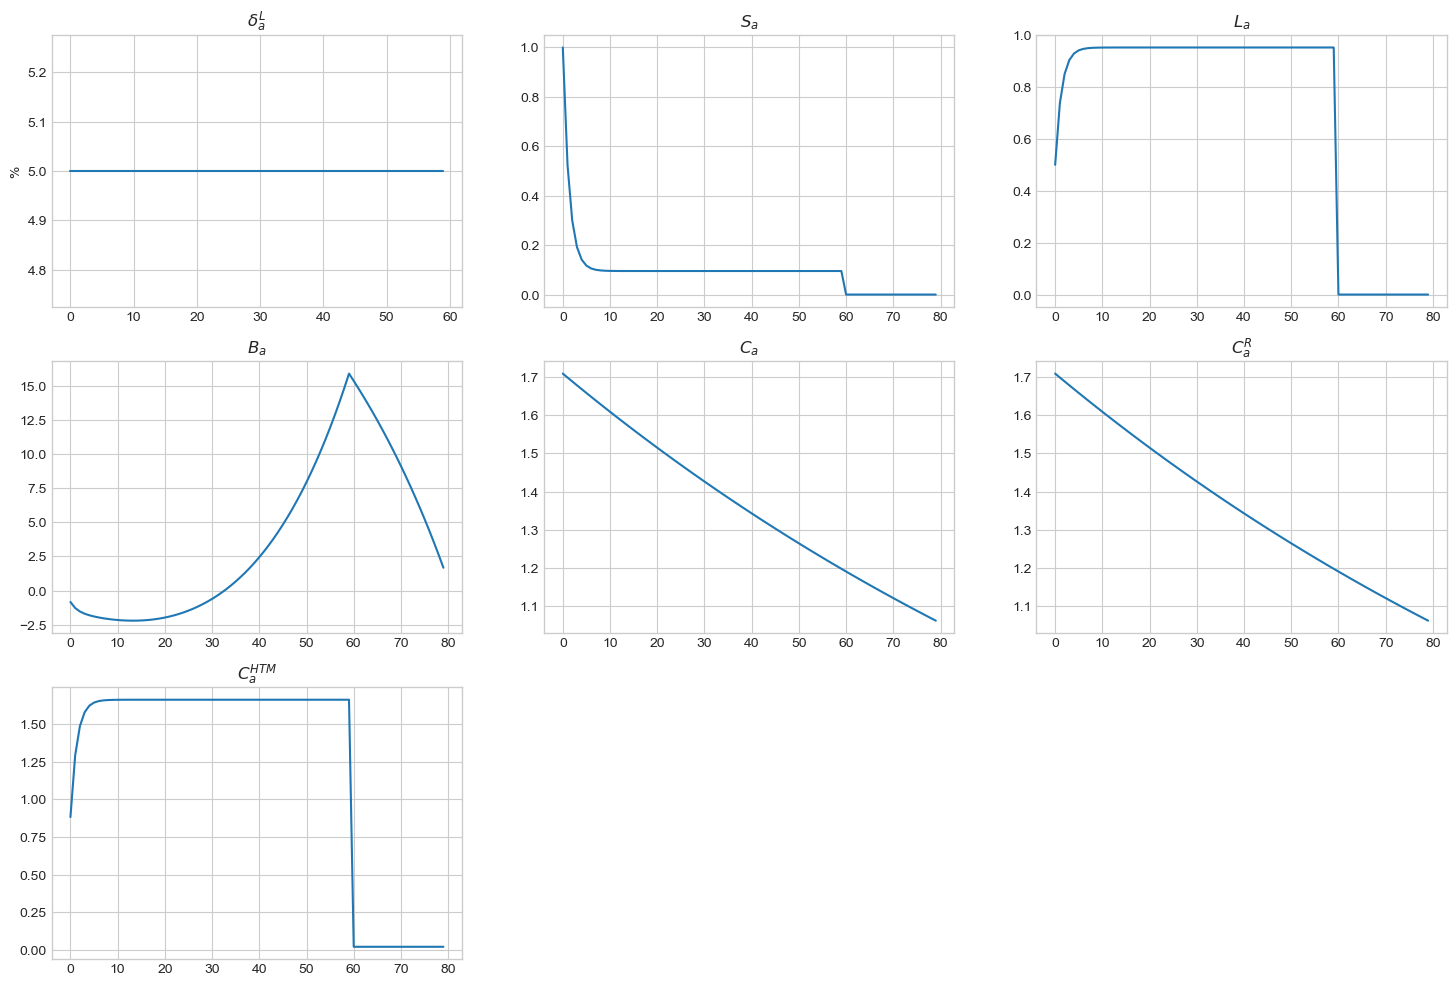

In [5]:
fig = plt.figure(figsize=(3*6,3*6/1.5))

ax = fig.add_subplot(3,3,1)
ax.plot(model.par.delta_L_a*100)
ax.set_ylabel('%')
ax.set_title('$\delta^L_a$')

ax = fig.add_subplot(3,3,2)
ax.plot(model.ss.S_a)
ax.set_title('$S_a$')

ax = fig.add_subplot(3,3,3)
ax.plot(model.ss.L_a)
ax.set_title('$L_a$')

ax = fig.add_subplot(3,3,4)
ax.plot(model.ss.B_a)
ax.set_ylabel('')
ax.set_title('$B_a$')

ax = fig.add_subplot(3,3,5)
ax.plot(model.ss.C_a)
ax.set_ylabel('')
ax.set_title('$C_a$')

ax = fig.add_subplot(3,3,6)
ax.plot(model.ss.C_R)
ax.set_ylabel('')
ax.set_title('$C^R_a$')

ax = fig.add_subplot(3,3,7)
ax.plot(model.ss.C_HTM)
ax.set_ylabel('')
ax.set_title('$C^{HTM}_a$');

# Speed and error tests

In [6]:
model.set_exo_ss()
model.set_unknowns_ss()

**Python evaluation:**

In [7]:
%time model.evaluate_blocks(py=True)

CPU times: total: 1.88 s
Wall time: 1.88 s


**Check errors:**

In [8]:
errors = model.get_errors(do_print=True)

bargaining_cond     : abs. max = 0.00e+00
Bq_match            : abs. max = 8.45e+01
FOC_capital_agency  : abs. max = 0.00e+00
FOC_K_ell           : abs. max = 7.11e-15
mkt_clearing        : abs. max = 2.84e-14


**First numba evaluation:**

In [9]:
%time model.evaluate_blocks()

CPU times: total: 20.5 s
Wall time: 20.7 s


**Time:**

In [10]:
%timeit model.evaluate_blocks()
%timeit model.get_errors()

4.6 ms ± 9.47 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
22.3 µs ± 450 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [11]:
%timeit model.evaluate_blocks(py=True)

228 ms ± 3.06 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
sol.B_G.shape, sol.tau.shape, sol.P_G.shape, sol.G.shape, sol.w.shape, sol.L.shape

((500,), (500,), (500,), (500,), (500,), (500,))

In [13]:
sol.tau_bar

array([ 0.        , -0.0370906 , -0.07566483, -0.11578203, -0.15750392,
       -0.20089468, -0.24602107, -0.29295252, -0.34176122, -0.39252228,
       -0.44531377, -0.50021693, -0.50676003, -0.39176409, -0.16747117,
        0.06330463,  0.21056171,  0.28419025,  0.32100452,  0.33941166,
        0.34861522,  0.35321701,  0.3555179 ,  0.35666834,  0.35724357,
        0.35753118,  0.35767498,  0.35774689,  0.35778284,  0.35780082,
        0.3578098 ,  0.3578143 ,  0.35781654,  0.35781767,  0.35781823,
        0.35781851,  0.35781865,  0.35781872,  0.35781876,  0.35781877,
        0.35781878,  0.35781879,  0.35781879,  0.35781879,  0.35781879,
        0.35781879,  0.35781879,  0.35781879,  0.35781879,  0.35781879,
        0.35781879,  0.35781879,  0.35781879,  0.35781879,  0.35781879,
        0.35781879,  0.35781879,  0.35781879,  0.35781879,  0.35781879,
        0.35781879,  0.35781879,  0.35781879,  0.35781879,  0.35781879,
        0.35781879,  0.35781879,  0.35781879,  0.35781879,  0.35

# Find an impulse-response

**Calculate Jacobian:**

In [14]:
model.calc_jac(do_print=True)

Jacobian calculated in 11.8 secs secs


Only needs to be calculated once.

**Set exogenous variables:**

In [15]:
model.set_exo_ss()

Here we shock export demand:

In [16]:
Tshock = 100
shock = 0.01*ss.chi
persistence = 0.9**np.arange(Tshock)
sol.chi[:Tshock] = ss.chi + shock*persistence

Check errors when guessing at steady state -> excess demand

In [17]:
model.set_unknowns_ss()
model.evaluate_blocks()
errors = model.get_errors(do_print=True)

bargaining_cond     : abs. max = 0.00e+00
Bq_match            : abs. max = 8.45e+01
FOC_capital_agency  : abs. max = 0.00e+00
FOC_K_ell           : abs. max = 8.88e-15
mkt_clearing        : abs. max = 8.22e-01


**Find IRF:**

In [18]:
model.find_IRF()

initial:
   max. abs. error = 8.45e+01
    0.00e+00 in bargaining_cond
    8.45e+01 in Bq_match
    0.00e+00 in FOC_capital_agency
    8.88e-15 in FOC_K_ell
    8.22e-01 in mkt_clearing

it = 0
 solve: t1-t0 = 0.2 secs
   max. abs. error = 8.45e+01
    7.94e-04 in bargaining_cond
    4.37e+00 in Bq_match
    2.66e-03 in FOC_capital_agency
    1.02e-01 in FOC_K_ell
    1.83e+00 in mkt_clearing
 evaluate: t1-t0 = 0.0 secs
 update_jac: t1-t0 = 0.0 secs

it = 1
 solve: t1-t0 = 0.1 secs
   max. abs. error = 4.37e+00
    2.04e-04 in bargaining_cond
    6.21e-01 in Bq_match
    1.47e-03 in FOC_capital_agency
    7.06e-02 in FOC_K_ell
    1.29e+00 in mkt_clearing
 evaluate: t1-t0 = 0.0 secs
 update_jac: t1-t0 = 0.0 secs

it = 2
 solve: t1-t0 = 0.1 secs
   max. abs. error = 1.29e+00
    2.48e-04 in bargaining_cond
    5.17e-01 in Bq_match
    9.36e-04 in FOC_capital_agency
    3.06e-02 in FOC_K_ell
    5.71e-01 in mkt_clearing
 evaluate: t1-t0 = 0.0 secs
 update_jac: t1-t0 = 0.0 secs

it = 3
 s

**Plot:**

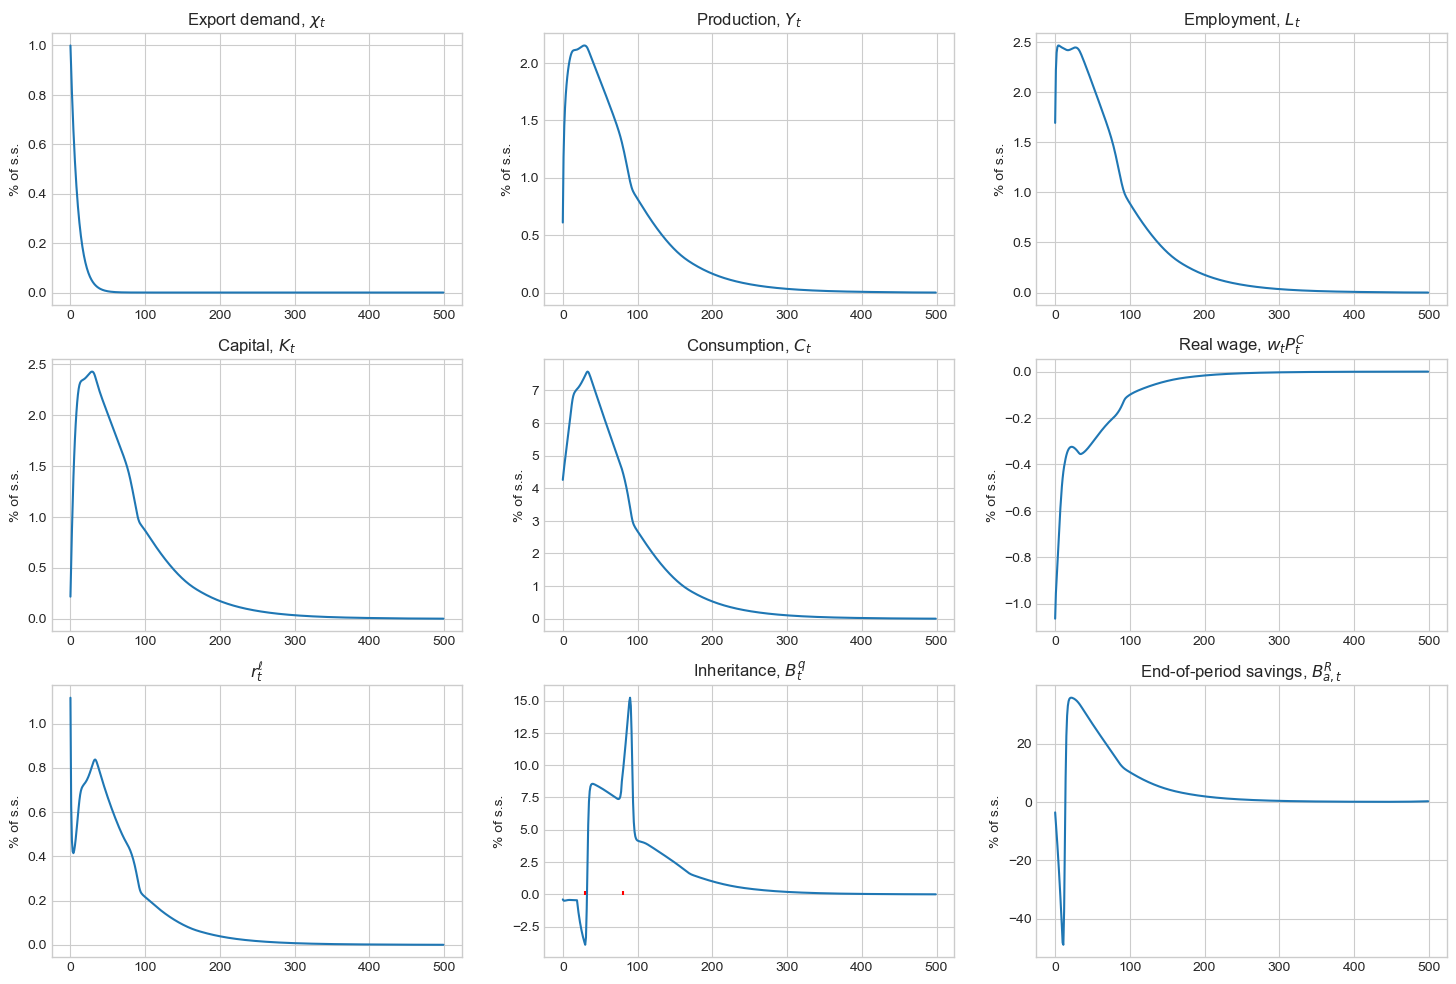

In [19]:
T_IRF = 500

fig = plt.figure(figsize=(3*6,3*6/1.5))

ax = fig.add_subplot(3,3,1)
ax.plot((sol.chi[:T_IRF]/ss.chi-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Export demand, $\chi_t$')

ax = fig.add_subplot(3,3,2)
ax.plot((sol.Y[:T_IRF]/ss.Y-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Production, $Y_t$')

ax = fig.add_subplot(3,3,3)
ax.plot((sol.L[:T_IRF]/ss.L-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Employment, $L_t$')

ax = fig.add_subplot(3,3,4)
ax.plot((sol.K[:T_IRF]/ss.K-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Capital, $K_t$')

ax = fig.add_subplot(3,3,5)
ax.plot((sol.C[:T_IRF]/ss.C-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Consumption, $C_t$')

ax = fig.add_subplot(3,3,6)
ax.plot(((sol.w[:T_IRF]/sol.P_C[:T_IRF])/(ss.w/ss.P_C)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Real wage, $w_tP^C_t$')

ax = fig.add_subplot(3,3,7)
ax.plot((sol.r_ell[:T_IRF]/(ss.r_ell)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('$r^\ell_t$')

ax = fig.add_subplot(3,3,8)
ax.plot((sol.Bq[:T_IRF]/(ss.Bq)-1)*100)
ax.vlines(80,-0.05,0.3,colors = 'r')
ax.vlines(30,-0.05,0.3,colors = 'r')
ax.set_ylabel('% of s.s.')
ax.set_title('Inheritance, $B^q_t$')

ax = fig.add_subplot(3,3,9)
ax.plot((sol.B[:T_IRF]/(ss.B)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('End-of-period savings, $B^R_{a,t}$');

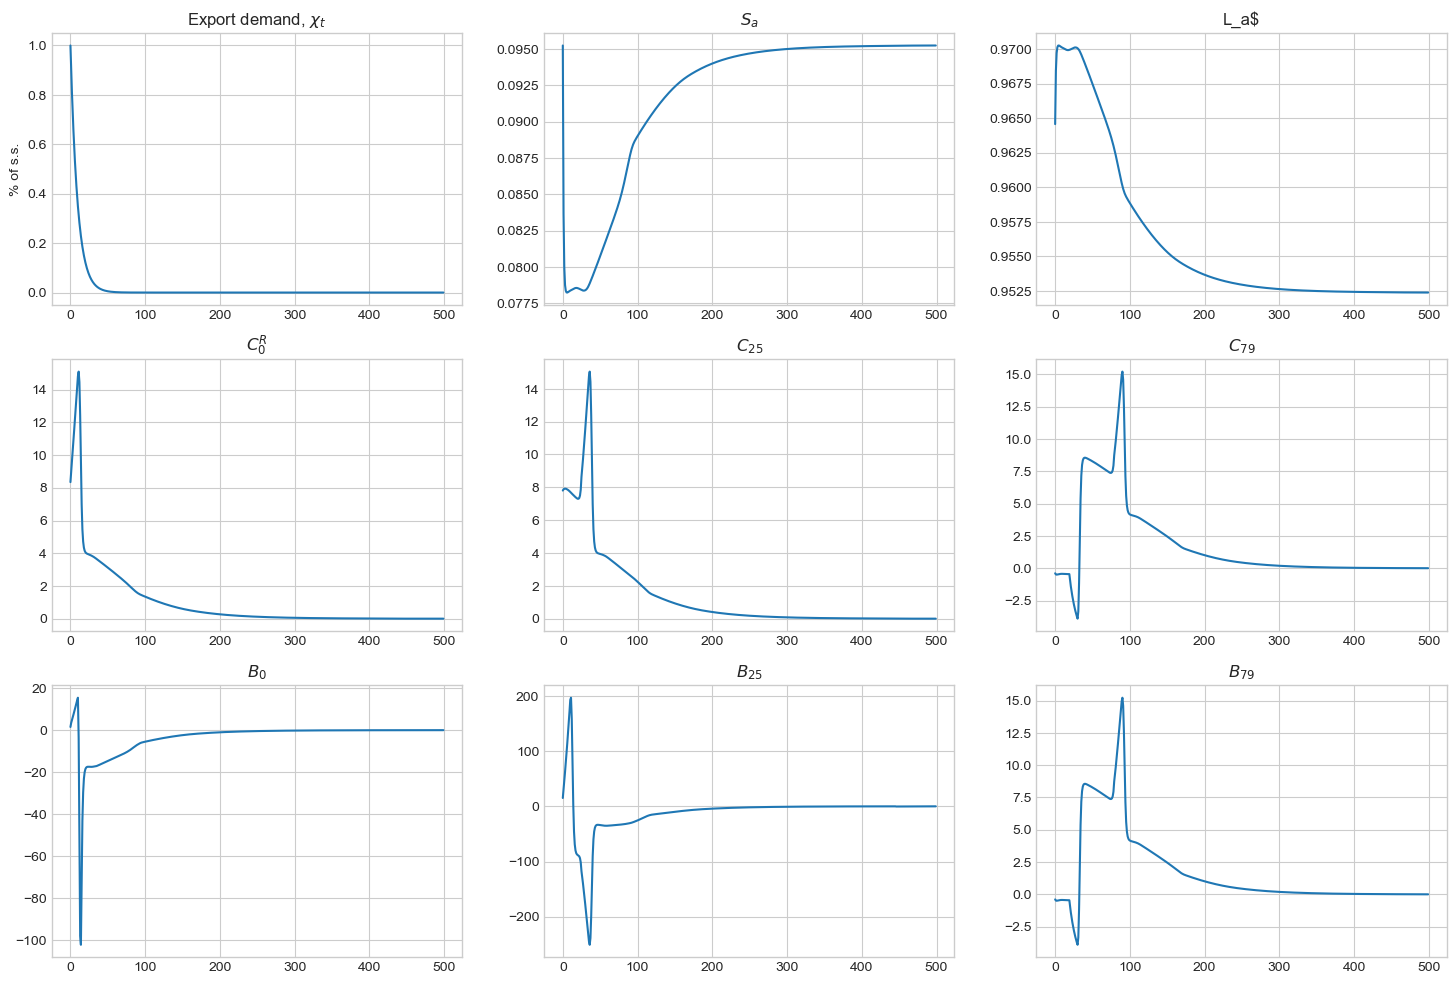

In [20]:
period = 25

fig = plt.figure(figsize=(3*6,3*6/1.5))

ax = fig.add_subplot(3,3,1)
ax.plot((sol.chi[:T_IRF]/ss.chi-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Export demand, $\chi_t$')

ax = fig.add_subplot(3,3,2)
ax.plot(sol.S_a[period,:T_IRF])
ax.set_title('$S_a$')

ax = fig.add_subplot(3,3,3)
ax.plot(sol.L_a[period,:T_IRF])
ax.set_title('L_a$')

ax = fig.add_subplot(3,3,4)
ax.plot((sol.C_R[0,:T_IRF]/(ss.C_R[0])-1)*100)
ax.set_title('$C^R_0$')

ax = fig.add_subplot(3,3,5)
ax.plot((sol.C_R[25,:T_IRF]/ss.C_R[25]-1)*100)
ax.set_title('$C_{25}$')

ax = fig.add_subplot(3,3,6)
ax.plot((sol.C_R[-1,:T_IRF]/ss.C_R[-1]-1)*100)
ax.set_title('$C_{79}$')

ax = fig.add_subplot(3,3,7)
ax.plot((sol.B_a[0,:T_IRF]/ss.B_a[0]-1)*100)
ax.set_title('$B_0$')

ax = fig.add_subplot(3,3,8)
ax.plot((sol.B_a[25,:T_IRF]/ss.B_a[25]-1)*100)
ax.set_title('$B_{25}$')

ax = fig.add_subplot(3,3,9)
ax.plot((sol.B_a[-1,:T_IRF]/ss.B_a[-1]-1)*100)
ax.set_title('$B_{79}$');
